# Analyzing Links From Russian Trolls
by [Leon Yin](twitter.com/leonyin)<br>
2018-02-20

<a href="https://www.nbcnews.com/tech/social-media/now-available-more-200-000-deleted-russian-troll-tweets-n844731">Link of dataset</a>

In [2]:
import json
import itertools
import requests
from urllib.parse import urlparse
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [3]:
tweet_url = 'http://nodeassets.nbcnews.com/russian-twitter-trolls/tweets.csv'
df_tweets = pd.read_csv(tweet_url, dtype={'id' : str, 'user_id' : str, 'tweet_id':str})
len(df_tweets)

203482

In [3]:
user_url = 'http://nodeassets.nbcnews.com/russian-twitter-trolls/users.csv'
df_users = pd.read_csv(user_url, dtype={'id' : str})
len(df_users)

454

In [9]:
df_users.dtypes

id                   object
location             object
name                 object
followers_count     float64
statuses_count      float64
time_zone            object
verified             object
lang                 object
screen_name          object
description          object
created_at           object
favourites_count    float64
friends_count       float64
listed_count        float64
dtype: object

In [15]:
df_users.head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
0,18710816,near Utah Ave & Lighthouse an,Robby Delaware,304.0,11484.0,Pacific Time (US & Canada),False,en,RobbyDelaware,"I support the free movement of people, ideas a...",Wed Jan 07 04:38:02 +0000 2009,17.0,670.0,13.0
1,100345056,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,1053.0,31858.0,NaN,False,en,SCOTTGOHARD,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,Tue Dec 29 23:15:22 +0000 2009,2774.0,1055.0,35.0
2,247165706,"Chicago, IL",B E C K S T E R✨,650.0,6742.0,Mountain Time (US & Canada),False,en,Beckster319,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,Fri Feb 04 06:38:45 +0000 2011,7273.0,896.0,30.0
3,249538861,NaN,Chris Osborne,44.0,843.0,NaN,False,en,skatewake1994,NaN,Wed Feb 09 07:38:44 +0000 2011,227.0,154.0,1.0
4,449689677,NaN,Рамзан Кадыров,94773.0,10877.0,Moscow,False,ru,KadirovRussia,"Пародийный аккаунт. Озвучиваю то, что политика...",Thu Dec 29 11:31:09 +0000 2011,0.0,7.0,691.0


In [16]:
df_tweets['user_id'].value_counts()

1679279490            9269
1671234620            6813
2882013788            6652
2671070290            4140
4508630900            3663
1727482238            3346
1768259989            3263
1868496344            3261
2572058134            3229
1658420976            3215
1655194147            3212
1658202894            3201
1684524144            3197
1623180199            3197
4224729994            3194
1676481360            3192
1660771422            3188
1694026190            3169
1649967228            3159
1690487623            3156
1680366068            3156
1710804738            3143
1833223908            3142
1617939218            3057
2496599688            3028
2541945841            3010
2589353987            3009
2531159968            2990
2584152521            2988
2532611755            2968
                      ... 
2563075183               1
752859805937766400       1
2504601561               1
2498181012               1
2537243471               1
2578879620               1
2

In [7]:
df_tweets.head()

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,1868981054,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,NaN,NaN,NaN,#IslamKills Are you trying to say that there w...,712346027861405696,NaN,"[""IslamKills""]",[],POSTED,[],NaN,NaN
1,2571870453,detroitdailynew,1.476133e+12,2016-10-10 20:57:00,0.0,False,0.0,"Clinton: Trump should’ve apologized more, atta...",785584942356967425,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],"[""http://detne.ws/2e172jF""]",POSTED,[],NaN,NaN
2,1710804738,cookncooks,1.487767e+12,2017-02-22 12:43:43,NaN,NaN,NaN,RT @ltapoll: Who was/is the best president of ...,834383165359788032,NaN,[],[],POSTED,[],NaN,NaN
3,2584152521,queenofthewo,1.482765e+12,2016-12-26 15:06:41,NaN,NaN,NaN,RT @jww372: I don't have to guess your religio...,813400649912217600,NaN,"[""ChristmasAftermath""]",[],POSTED,[],NaN,NaN
4,1768259989,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,NaN,NaN,NaN,RT @Shareblue: Pence and his lawyers decided w...,894024327049363456,NaN,[],[],POSTED,[],NaN,NaN


In [17]:
def get_link(tweet):
    '''
    For pandas!
    Returns a generator containing tweet metadata about media.
    '''
    row = {
        'user.id': tweet['user_id'],
        'tweet.id': tweet['tweet_id'],
        'tweet.created_at': tweet['created_str'],
        'tweet.text' : tweet['text']
    }

    list_urls = tweet['expanded_urls']
    
    if list_urls:
        for url in list_urls:
            r = row.copy()
            r['link.url_long'] = url
            if r['link.url_long']:
                r['link.domain'] = urlparse(r['link.url_long']).netloc.lower()
                yield r  

In [60]:
# df_tweets['expanded_urls'] = df_tweets['expanded_urls'].apply(lambda x: x[1:-1].strip('"').split(','))

In [18]:
df_tweets['expanded_urls'] = df_tweets['expanded_urls'].apply(json.loads)

In [12]:
for link in get_link(df_tweets.iloc[1]):
    print(link)

{'user.id': '2571870453', 'tweet.id': '785584942356967425', 'tweet.created_at': '2016-10-10 20:57:00', 'tweet.text': 'Clinton: Trump should’ve apologized more, attacked less https://t.co/eJampkoHFZ', 'link.url_long': 'http://detne.ws/2e172jF', 'link.domain': 'detne.ws'}


In [19]:
df_links = pd.DataFrame(
    list(
        itertools.chain.from_iterable(
            [ get_link( tweet[1] ) for tweet in tqdm( df_tweets.iterrows() ) if tweet ]
        )
    )
)

In [20]:
len(df_links)

40768

In [14]:
# first 50 shared domains
df_links['link.domain'].value_counts().head(50)

twitter.com                 11449
bit.ly                       5693
youtu.be                     1353
twibble.io                    945
ln.is                         761
www.youtube.com               592
dlvr.it                       588
www.breitbart.com             576
wapo.st                       497
ow.ly                         489
goo.gl                        472
buff.ly                       425
dailycaller.com               382
www.frontpagemag.com          309
sh.st                         297
fb.me                         266
on.rt.com                     246
www.huffingtonpost.com        227
www.wcvb.com                  210
ift.tt                        206
shar.es                       206
www.infowars.com              205
truthfeed.com                 200
hill.cm                       191
dailym.ai                     190
thehill.com                   187
www.donaldjtrump.com          179
politi.co                     175
www.nytimes.com               172
www.thegateway

In [16]:
df_links['user.id'].value_counts().head()

1679279490    5340
1671234620    3040
1662779209    1619
1661246144    1484
2606301939    1286
Name: user.id, dtype: int64

## Link Analysis <a id="link"></a>
Let's strip all the links out of the tweet.<br>
We can't just return the value, as there can be multiple links per Tweet.<br>
We can solve this by using a generator, and unpacking each using `itertools`.

In [17]:
df_links.head()

,link.domain,link.url_long,tweet.created_at,tweet.id,tweet.text,user.id
0,detne.ws,http://detne.ws/2e172jF,2016-10-10 20:57:00,785584942356967425,"Clinton: Trump should’ve apologized more, atta...",2571870453
1,www.feed24hnews.com,http://www.Feed24hNews.com/4MzaL,2016-10-30 01:48:19,792543622528892929,RT @AriaWilsonGOP: 3 Women Face Charges After ...,1679279490
2,bit.ly,http://bit.ly/2axp6SI,2016-07-27 14:55:39,758314917355106304,Obama on Trump winning: 'Anything's possible' ...,2587843805
3,bgg2wl.com,http://bgg2wl.com/1CDJfQt,2016-10-30 09:29:28,792659678018887685,"RT @bgg2wl: Walmart, Michelle Obama and The Ha...",1660375034
4,twitter.com,https://twitter.com/profchrismjones/status/790...,2016-10-23 03:12:06,790027995343904769,RT @JoyAnnReid: Tried to tell the @amjoyshow s...,1510488662


In [21]:
df_links = df_links[df_links['link.domain'] != 'twitter.com']

In [218]:
# 'ln.is'
'http://ln.is/constitution.com/Qg5CQ'.strip('http://ln.is/')

'constitution.com/Qg5CQ'

In [ ]:
# should I unshorten publication links?

In [ ]:
# twibble.io
# social media manager
# also twib.in

# dlvr.it
# social media manager

# sh.st
# showrens video, hard to expand

In [19]:
import unshortenit

In [159]:
unshortenit.unshorten('http://bit.ly/2axp6SI')

('http://www.kmbc.com/no-longer-available', 200)

In [72]:
df_links[df_links['link.domain'] == 'sh.st'].head()['link.url_long'].values

array(['http://sh.st/8K1C2', 'http://sh.st/7tJuE', 'http://sh.st/5x58h',
       'http://sh.st/4UGEH', 'http://sh.st/4w6gn'], dtype=object)

In [188]:
# domains for links
general_shorteners = [
    'sh.st',  
]

trouble_shorteners = [
    'dlvr.it', 'bit.ly', 'buff.ly',
    'ow.ly',  'goo.gl', 'shar.es', 
    'ift.tt', 'fb.me',  'washex.am', 'smq.tc',  'trib.al',
    'paper.li', 'waa.ai', 'tinyurl.com',
]

media_shorteners = [
    'on.rt.com', 'wapo.st', 'hill.cm', 'dailym.ai',
    'politi.co', 'fxn.ws', 'usat.ly', 'cnn.it',
    'huff.to', 'nyp.st', 'cbsloc.al', 'nyti.ms',
    'wpo.st', 'on.wsj.com', 'nydn.us',
    
]

shortened_domains = general_shorteners
shortened_domains_2 = media_shorteners + trouble_shorteners
all_short_domains = shortened_domains + shortened_domains_2 + ['ln.is']

In [198]:
def parse_error(row):
    if 'HTTPConnectionPool' in row:
        vals = row.split("HTTPConnectionPool(host='")[1].split("',")
        domain = vals[0]
        url_endpoint = vals[1].split('Max retries exceeded with url: ')[-1].split(" (Caused by")[0]
        url_endpoint = os.path.join('http://', domain + url_endpoint)
    else:
        domain, url_endpoint = -1, -1
    return domain, url_endpoint

def unshorten(link):
    if link['link.domain'] in shortened_domains:
        # expland long link
        url_long, code = unshortenit.unshorten(link['link.url_long'])
        time.sleep(.4)
        domain = urlparse(url_long).netloc.lower()
        return link['link.domain'], link['link.url_long'], domain, url_long
#         else:
#             print("ERROR CODE {}\nURL-LONG {}\n{} is fucked\n\n".format(code, url_long, link))
#             return link['link.domain'], link['link.url_long'], -2, url_long
        
    elif link['link.domain'] in shortened_domains_2:
        try:
            r = requests.head(link['link.url_long'], allow_redirects=True)
            url_long = r.url
            time.sleep(.4)
            domain = urlparse(url_long).netloc.lower()
            return link['link.domain'], link['link.url_long'], domain, url_long
        
        except requests.exceptions.RequestException as e:
#             print("FUcked {}".format(link))
#             print(e)
            domain, url_long = parse_error(str(e))
            return link['link.domain'], link['link.url_long'], domain, url_long
            
            
    elif link['link.domain'] == 'ln.is':
        url_long = link['link.url_long'].replace('ln.is/', '')
        time.sleep(.4)
        domain = urlparse(url_long).netloc.lower()

        return link['link.domain'], link['link.url_long'], domain, url_long

In [224]:
df_links_[df_links_['link.domain'] == 'ln.is']

,link.domain,link.url_long,tweet.created_at,tweet.id,tweet.text,user.id
86,ln.is,http://ln.is/www.breitbart.com/20/kI3Uc,2016-09-12 17:48:32,775390654306226176,RT @GoldStarMomTX55: ChristiChat: RT LindaSuhl...,1679279490
222,ln.is,http://ln.is/com/mU6Uw,2016-09-18 01:05:05,777312455114559488,RT @apostlelaurinda: &amp;it was a lie = FLASH...,1651693646
271,ln.is,http://ln.is/www.breitbart.com/20/wBmL5,2016-09-19 17:56:11,777929294471368704,"RT @JeffreyGriese: Under Secretary Clinton, U....",2606301939
272,ln.is,http://ln.is/www.breitbart.com/20/wBmL5,2016-09-19 17:56:11,777929294471368704,"RT @JeffreyGriese: Under Secretary Clinton, U....",2606301939
284,ln.is,http://ln.is/rickwells.us/wyZV9,2016-09-17 16:49:31,777187739364159488,RT @karen_erotoo1: Desperate Racist Black Cauc...,2491081213
354,ln.is,http://ln.is/lonestarliberty.org/bWZGJ,2016-09-16 20:42:07,776883889189117952,"RT @jstines3: As The GOP Sinks, The #GOPEXODUS...",1533813962
395,ln.is,http://ln.is/constitution.com/Qg5CQ,2016-10-17 08:20:32,787931284916072448,RT @luvGodncountry: Green Party Candidate Jill...,2535818742
503,ln.is,http://ln.is/www.youtube.com/E88ol,2016-11-07 04:54:34,795489597065220096,RT @ladymacbeth1212: HOMELESS WOMAN WHO PROTEC...,1679279490
504,ln.is,http://ln.is/www.youtube.com/E88ol,2016-11-07 04:54:34,795489597065220096,RT @ladymacbeth1212: HOMELESS WOMAN WHO PROTEC...,1679279490
785,ln.is,http://ln.is/washingtontimes.com/2Pe5L,2016-09-19 21:09:30,777977943800721408,RT @cmdorsey: Judge blasts State Dept. for slo...,1671234620


In [73]:
r = requests.head('http://sh.st/8K1C2', allow_redirects=True)

In [75]:
r.url

'http://sh.st/8K1C2'

Which links will we unshorten?
Lets filter all link domains for the ones in the lists ahove

In [189]:
df_link_match = df_links[df_links['link.domain'].isin(all_short_domains)]

In [190]:
len(df_link_match)

12187

In [191]:
df_link_match_unique = df_link_match.drop_duplicates(subset=['link.url_long'])

In [194]:
df_link_match_unique = df_link_match_unique[~df_link_match_unique['link.url_long'].isin(df_link_meta['link.url_long'])]

In [195]:
len(df_link_match_unique)

427

In [196]:
df_link_match_unique.to_csv('data/unique_links_v2.csv', index=False)

In [200]:
import time

In [125]:
df_link_match_unique.iloc[394]

link.domain                                                    bit.ly
link.url_long                                   http://bit.ly/2bxKxUA
tweet.created_at                                  2016-08-22 19:07:09
tweet.id                                           767800292687515648
tweet.text          Colin Powell talks about his involvement in Hi...
user.id                                                    2753146444
Name: 1895, dtype: object

potential catch for 
```HTTPConnectionPool(host='worldlibertynews.com', port=80): Max retries exceeded with url: /is-technology-causing-us-to-evolve-into-a-new-species/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x12b842550>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))```
https://github.com/requests/requests/issues/4147

In [ ]:
# example of an error
"""HTTPConnectionPool(host='worldlibertynews.com', port=80): 
Max retries exceeded with url: /is-technology-causing-us-to-evolve-into-a-new-species/ (Caused by 
NewConnectionError('<urllib3.connection.HTTPConnection object at 0x12b842550>: Failed to establish a new connection:""".

In [102]:
unshorten(df_link_match_unique.iloc[350])

FUcked link.domain                                                    bit.ly
link.url_long                                   http://bit.ly/20pqEE4
tweet.created_at                                  2016-08-18 10:02:24
tweet.id                                           766213651846037504
tweet.text          Is Technology Causing Us To ‘Evolve’ Into A Ne...
user.id                                                    2540882036
Name: 1902, dtype: object
HTTPConnectionPool(host='worldlibertynews.com', port=80): Max retries exceeded with url: /is-technology-causing-us-to-evolve-into-a-new-species/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1291239e8>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))


('bit.ly',
 'http://bit.ly/20pqEE4',
 'worldlibertynews.com',
 'http://worldlibertynews.com/is-technology-causing-us-to-evolve-into-a-new-species/')

Unshorten all the links

In [201]:
with open('data/link_cache_v3.json', 'w') as file: 
    new_stuff = []
    for i, row in tqdm(df_link_match_unique.iterrows()):
        if i % 100 == 0:
            print("sleeping")
            time.sleep(15)
        d = {}
        (d['link.domain'], d['link.url_long'], 
         d['link.domain_resolved'], d['link.url_long_resolved']) = unshorten(row)
        new_stuff.append( d )
        file.write( json.dumps( d ) + '\n' )

sleeping
sleeping
sleeping



In [92]:
# this is what happens when an error is encountered
parse_error("""HTTPConnectionPool(host='blacktolive.org', port=80): Max retries exceeded with url: /news/white-people-are-ready-to-boycott-nfl-but-not-ready-to-change-anything/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x129e61f60>: Failed to establish a new connection: [Errno 61] Connection refused',))""")

('blacktolive.org',
 'http://blacktolive.org/news/white-people-are-ready-to-boycott-nfl-but-not-ready-to-change-anything/')

In [202]:
df_link_meta = pd.DataFrame(new_stuff)

In [205]:
# df_link_meta_3 = df_link_meta_2.append(df_link_meta)

In [ ]:
# df_link_meta_3.to_csv()

In [118]:
df_resolved = pd.merge(left=df_links, right=df_link_meta, on=['link.url_long', 'link.domain'])

In [128]:
df_resolved[df_resolved['link.domain_resolved'] == 'www.sfgate.com'][['tweet.text', 'link.url_long_resolved']].head().values

array([['AP FACT CHECK: Claims in the VP debate https://t.co/8McktemI8f',
        'https://www.sfgate.com/news/politics/article/AP-FACT-CHECK-Claims-in-the-VP-debate-9718406.php?utm_source=twitterfeed&utm_medium=twitter'],
       ['Trump and taxes could figure into Pennsylvania Senate debate https://t.co/ymHdMDxZoC',
        'https://www.sfgate.com/news/article/Trump-and-taxes-could-figure-into-Pennsylvania-9975282.php?utm_source=twitterfeed&utm_medium=twitter'],
       ["Nebraska's Ben Sasse faces heat at home for Trump stance https://t.co/5FZWPKnyD4",
        'https://www.sfgate.com/news/politics/article/Nebraska-s-Ben-Sasse-faces-heat-at-home-for-Trump-9201715.php?utm_source=twitterfeed&utm_medium=twitter'],
       ["GOP senator: Trump's comments forced me to pull endorsement https://t.co/I6k1iDe6fV",
        'https://www.sfgate.com/news/article/GOP-s-Portman-Democrat-Strickland-face-off-in-9970691.php?utm_source=twitterfeed&utm_medium=twitter'],
       ["Trump: I reversed birther s

These are what tweets look like from several link shorteners.

In [136]:
df_users[df_users['id'].isin(df_links[df_links['link.domain'] == 'bit.ly']['user.id'])].head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
2,247165706,"Chicago, IL",B E C K S T E R✨,650.0,6742.0,Mountain Time (US & Canada),False,en,Beckster319,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,Fri Feb 04 06:38:45 +0000 2011,7273.0,896.0,30.0
8,1513801268,USA,CC Jack,2760.0,2100.0,Eastern Time (US & Canada),False,en,YouJustCtrlC,ProBlack | Stoner | even jesus was stoned befo...,Thu Jun 13 16:07:23 +0000 2013,2744.0,2700.0,10.0
9,1517678892,"Philadelphia, PA",Mr Moran,879.0,2044.0,Eastern Time (US & Canada),False,en,MrMoraan,I'm getting too cool for this social media shi...,Fri Jun 14 21:58:48 +0000 2013,2981.0,758.0,15.0
10,1518857420,USA,Jonathon Norwood,789.0,2002.0,Eastern Time (US & Canada),False,en,NoJonathonNo,Strive not to be a success but rather to be of...,Sat Jun 15 08:47:02 +0000 2013,2170.0,440.0,8.0
12,1533813962,USA,Lara Pretty,1795.0,3342.0,Eastern Time (US & Canada),False,en,PrettyLaraPlace,Bitter Clinger #USAFVet #NRA #2A #bluestarmom ...,Thu Jun 20 12:35:59 +0000 2013,3555.0,1360.0,24.0


In [141]:
# twibble is for news outlets
df_users[df_users['id'].isin(df_links[df_links['link.domain'] == 'twibble.io']['user.id'])].head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
109,2495567768,"San Francisco, CA",San Francisco Daily,16812.0,32546.0,Pacific Time (US & Canada),False,en,DailySanFran,"Follow for San Francisco's breaking news, spec...",Thu May 15 03:22:22 +0000 2014,1.0,5128.0,159.0
150,2570017414,"Memphis, TN",Memphis Online,18704.0,4223.0,Central Time (US & Canada),False,en,OnlineMemphis,"Breaking news, weather, traffic and more for M...",Thu May 29 01:01:16 +0000 2014,3.0,5751.0,113.0
172,2601235821,"Pittsburgh, PA",Pittsburgh Today,18917.0,32006.0,Eastern Time (US & Canada),False,en,TodayPittsburgh,Pittsburgh's local news on Twitter. Breaking n...,Wed Jun 11 14:24:00 +0000 2014,7.0,6350.0,145.0
176,2620614029,"Philadelphia, PA",Philadelphia Online,15904.0,9725.0,Eastern Time (US & Canada),False,en,PhiladelphiaON,"Breaking news, weather, traffic and more for P...",Wed Jun 18 17:42:55 +0000 2014,4.0,5890.0,118.0
184,2743327187,"Washington, D.C.",Washington Online,31729.0,28939.0,Eastern Time (US & Canada),False,en,WashingtOnline,"Breaking news, weather, traffic and more for W...",Fri Aug 15 07:33:02 +0000 2014,31.0,12148.0,263.0


In [147]:
# tweets from those fake local news outlets.
df_tweets[df_tweets['user_id'].isin(df_links[df_links['link.domain'] == 'twibble.io']['user.id'])].head()

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
67,2944766250,atlanta_online,1.469997e+12,2016-07-31 20:36:26,0.0,False,0.0,"Hillary Clinton vows to fight, lead for all as...",759850227201290240,"<a href=""http://twibble.io"" rel=""nofollow"">Twi...",[],"[https://twibble.io, http://politics.blog.ajc....",POSTED,[],NaN,NaN
111,2601235821,todaypittsburgh,1.430607e+12,2015-05-02 22:51:46,NaN,NaN,NaN,#sports 2015 Steelers Fan Blitz takes over Hei...,NaN,NaN,"[""sports""]",[],POSTED,[],NaN,NaN
132,2495567768,dailysanfran,1.475656e+12,2016-10-05 08:25:39,0.0,False,0.0,AP FACT CHECK: Claims in the VP debate https:/...,783583921216688129,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],[http://bit.ly/2dsz9Ks],POSTED,[],NaN,NaN
160,2753211010,phoenixdailynew,1.469014e+12,2016-07-20 11:18:41,0.0,False,0.0,"Corey Lewandowski, mischief maker: Some Trump ...",755723599042928640,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],[http://politi.co/2abnhuq],POSTED,[],NaN,NaN
188,2753211010,phoenixdailynew,1.468990e+12,2016-07-20 04:49:55,0.0,False,0.0,'LET'S SEE THIS THROUGH' GOP brass rally part...,755625763756539904,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],[http://fxn.ws/2aaPIIY],POSTED,[],NaN,NaN


In [139]:
df_users[df_users['id'].isin(df_links[df_links['link.domain'] == 'dlvr.it']['user.id'])].head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
8,1513801268,USA,CC Jack,2760.0,2100.0,Eastern Time (US & Canada),False,en,YouJustCtrlC,ProBlack | Stoner | even jesus was stoned befo...,Thu Jun 13 16:07:23 +0000 2013,2744.0,2700.0,10.0
10,1518857420,USA,Jonathon Norwood,789.0,2002.0,Eastern Time (US & Canada),False,en,NoJonathonNo,Strive not to be a success but rather to be of...,Sat Jun 15 08:47:02 +0000 2013,2170.0,440.0,8.0
12,1533813962,USA,Lara Pretty,1795.0,3342.0,Eastern Time (US & Canada),False,en,PrettyLaraPlace,Bitter Clinger #USAFVet #NRA #2A #bluestarmom ...,Thu Jun 20 12:35:59 +0000 2013,3555.0,1360.0,24.0
16,1617939218,USA,Pauline Gunn,908.0,1906.0,Eastern Time (US & Canada),False,en,PaulineTT,"I be trying to chill, I swear do, because I lu...",Wed Jul 24 14:50:02 +0000 2013,1983.0,1075.0,5.0
17,1620474397,USA,Ramona Mcintosh,877.0,1745.0,Eastern Time (US & Canada),False,en,RamonasNails,"Mom, Global Nail Artist, Consultant, blah,blah...",Thu Jul 25 14:06:28 +0000 2013,1992.0,1138.0,6.0


In [142]:
df_users[df_users['id'].isin(df_links[df_links['link.domain'] == 'ln.is']['user.id'])].head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
10,1518857420,USA,Jonathon Norwood,789.0,2002.0,Eastern Time (US & Canada),False,en,NoJonathonNo,Strive not to be a success but rather to be of...,Sat Jun 15 08:47:02 +0000 2013,2170.0,440.0,8.0
12,1533813962,USA,Lara Pretty,1795.0,3342.0,Eastern Time (US & Canada),False,en,PrettyLaraPlace,Bitter Clinger #USAFVet #NRA #2A #bluestarmom ...,Thu Jun 20 12:35:59 +0000 2013,3555.0,1360.0,24.0
13,1584279696,"Chicago, IL",Jasiah Jenkins,728.0,1918.0,Eastern Time (US & Canada),False,en,BigBoyJasiah,Visionary..... don't put me in a box.... Enigm...,Wed Jul 10 23:55:16 +0000 2013,2342.0,393.0,19.0
18,1623180199,NaN,Jeffrey Kahunas,1565.0,2320.0,Pacific Time (US & Canada),False,en,JeffreyKahunas,"Honor God & Jesus & Your Parents Country, GOP,...",Fri Jul 26 15:01:14 +0000 2013,1090.0,1586.0,18.0
21,1629828379,"New York, USA",Lovely Cass,2121.0,3831.0,Eastern Time (US & Canada),False,en,cassishere,Fun-loving conservative sharing the truth that...,Mon Jul 29 07:59:27 +0000 2013,4154.0,2220.0,36.0


In [143]:
df_users[df_users['id'].isin(df_links[df_links['link.domain'] == 'ow.ly']['user.id'])].head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
9,1517678892,"Philadelphia, PA",Mr Moran,879.0,2044.0,Eastern Time (US & Canada),False,en,MrMoraan,I'm getting too cool for this social media shi...,Fri Jun 14 21:58:48 +0000 2013,2981.0,758.0,15.0
10,1518857420,USA,Jonathon Norwood,789.0,2002.0,Eastern Time (US & Canada),False,en,NoJonathonNo,Strive not to be a success but rather to be of...,Sat Jun 15 08:47:02 +0000 2013,2170.0,440.0,8.0
12,1533813962,USA,Lara Pretty,1795.0,3342.0,Eastern Time (US & Canada),False,en,PrettyLaraPlace,Bitter Clinger #USAFVet #NRA #2A #bluestarmom ...,Thu Jun 20 12:35:59 +0000 2013,3555.0,1360.0,24.0
13,1584279696,"Chicago, IL",Jasiah Jenkins,728.0,1918.0,Eastern Time (US & Canada),False,en,BigBoyJasiah,Visionary..... don't put me in a box.... Enigm...,Wed Jul 10 23:55:16 +0000 2013,2342.0,393.0,19.0
15,1612106972,USA,Reuben Littlejohn,738.0,1899.0,Eastern Time (US & Canada),False,en,LILJordamn,young nigga just trying to make# also do music#,Mon Jul 22 05:34:20 +0000 2013,2251.0,608.0,16.0


Analyzing the resolved links.

In [4]:
df_link_meta = pd.read_csv('data/resolved_links_yt_ls.csv')

In [21]:
df_link_meta[df_link_meta['link.domain'] == 'bit.ly']['link.domain_resolved'].value_counts()

www.sfgate.com                   395
ksnt.com                         367
www.cleveland.com                354
www.kmbc.com                     330
www.nola.com                     237
www.reuters.com                  220
ksn.com                          206
kron4.com                        187
www.nj.com                       185
www.breitbart.com                143
www.azcentral.com                 98
www.nbcchicago.com                88
www.wafb.com                      69
www.philly.com                    68
www.stltoday.com                  65
www.mysanantonio.com              65
www.nbc12.com                     50
www.usatoday.com                  48
blacktolive.org                   37
www.patdollard.com                35
www.seattletimes.com              33
www.abc15.com                     29
www.wkyc.com                      26
www.detroitnews.com               26
www.post-gazette.com              24
www.kctv5.com                     24
www.wtae.com                      23
w

In [22]:
df_link_meta['link.domain_resolved'].value_counts()

www.washingtonpost.com                           473
www.sfgate.com                                   395
ksnt.com                                         367
www.cleveland.com                                355
www.kmbc.com                                     330
www.nola.com                                     237
www.reuters.com                                  220
www.breitbart.com                                216
ksn.com                                          206
kron4.com                                        187
www.nj.com                                       185
thehill.com                                      140
www.dailymail.co.uk                              137
www.politico.com                                 119
www.foxnews.com                                  107
www.rt.com                                       102
www.libertywritersnews.com                       101
truthfeed.com                                    100
www.azcentral.com                             

In [109]:
# these failed!
df_link_meta[df_link_meta['link.domain_resolved'] == -1]

,link.domain,link.domain_resolved,link.url_long,link.url_long_resolved
1003,dlvr.it,-1,http://dlvr.it/MHKyRk,-1
1177,ift.tt,-1,http://ift.tt/2eCfkRH,-1
1920,on.rt.com,-1,http://on.rt.com/7rcg,-1
2170,bit.ly,-1,http://bit.ly/2dzRVTA,-1
4366,goo.gl,-1,http://goo.gl/xrd3mx,-1
4684,bit.ly,-1,http://bit.ly/2cvhgsu,-1
5195,fb.me,-1,http://fb.me/5aiYDy6tz,-1
5515,goo.gl,-1,http://goo.gl/fb/kvNWQ9,-1
7082,fb.me,-1,http://fb.me/1wvYf2bMU,-1


We can see the most common words associated with each link using a simple count sans-stop words.

In [35]:
from nltk.corpus import stopwords

What does his own site focus on?

In [36]:
word_count = Counter()
for sent in df_links[df_links['link.domain'] == 'hannity.com']['tweet.text'].values:
    word_count.update([w for w in sent.split() if w not in stopwords.words('English')])

word_count.most_common(10)

[('Trump', 19),
 ('FBI', 13),
 ('Over', 13),
 ('GOP', 12),
 ('The', 11),
 ('https://t.co/9hkyEX1UVi', 11),
 ('@realDonaldTrump', 10),
 ('Tax', 10),
 ('After', 8),
 ('Cuts', 8)]

What about Amazon?

In [37]:
word_count = Counter()
for sent in df_links[df_links['link.domain'] == 'amzn.to']['tweet.text']:
    word_count.update([w for w in sent.split() if w not in stopwords.words('English')])

word_count.most_common(10)

[('radio', 26),
 ('joins', 19),
 ('new', 19),
 ('book', 15),
 ('discuss', 11),
 ('great', 7),
 ('talk', 7),
 ('#Hannity', 7),
 ('author', 4),
 ('.@newtgingrich', 4)]

## Questionable Media Domains <a id="fake"></a>
We can use the open sources dataset to filter domains on various criteria.<br>
Here is a <a href="https://nbviewer.jupyter.org/github/yinleon/fake_news/blob/master/opensources-lite.ipynb">notebook</a> that makes the data machine-readible.

In [28]:
opensorces_clean_url = 'https://raw.githubusercontent.com/yinleon/fake_news/master/data/sources_clean.tsv'
df_os = pd.read_csv(opensorces_clean_url, sep='\t')
len(df_os)

In [29]:
df_os.head()

,domain,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,state,unreliable,notes
0,100percentfedup.com,1,0,0,0,0,0,0,0,0,0,0,0,NaN
1,16wmpo.com,0,0,0,1,0,0,0,0,0,0,0,0,http://www.politifact.com/punditfact/article/2...
2,21stcenturywire.com,0,0,1,0,0,0,0,0,0,0,0,0,NaN
3,24newsflash.com,0,0,0,1,0,0,0,0,0,0,0,0,NaN
4,24wpn.com,0,0,0,1,0,0,0,0,0,0,0,0,http://www.politifact.com/punditfact/article/2...


In [81]:
df_os[df_os['domain'] == 'infowars.com']

,domain,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,state,unreliable,notes
384,infowars.com,0,0,1,0,0,0,0,0,0,0,0,0,NaN


In [187]:
df_link_meta['link.domain'].value_counts()

bit.ly         4139
wapo.st         441
sh.st           295
dlvr.it         281
fb.me           224
ow.ly           189
goo.gl          173
buff.ly         170
ift.tt          133
hill.cm         132
dailym.ai       131
politi.co       113
on.rt.com       101
shar.es          97
washex.am        83
trib.al          81
fxn.ws           80
cbsloc.al        78
cnn.it           59
nyti.ms          46
huff.to          44
nydn.us          43
tinyurl.com      31
nyp.st           28
usat.ly          26
wpo.st           26
smq.tc           21
waa.ai           20
on.wsj.com       20
paper.li         14
Name: link.domain, dtype: int64

In [208]:
df_merged = df_links.merge(df_link_meta, on =['link.url_long', 'link.domain'], how='left')

In [181]:
df_merged[df_merged['link.domain_resolved'] == 'ln.is']

,link.domain,link.url_long,tweet.created_at,tweet.id,tweet.text,user.id,link.domain_resolved,link.url_long_resolved
55,ln.is,http://ln.is/www.breitbart.com/20/kI3Uc,2016-09-12 17:48:32,775390654306226176,RT @GoldStarMomTX55: ChristiChat: RT LindaSuhl...,1679279490,ln.is,http://ln.is/www.breitbart.com/20/kI3Uc
142,ln.is,http://ln.is/com/mU6Uw,2016-09-18 01:05:05,777312455114559488,RT @apostlelaurinda: &amp;it was a lie = FLASH...,1651693646,ln.is,http://ln.is/com/mU6Uw
181,ln.is,http://ln.is/www.breitbart.com/20/wBmL5,2016-09-19 17:56:11,777929294471368704,"RT @JeffreyGriese: Under Secretary Clinton, U....",2606301939,ln.is,http://ln.is/www.breitbart.com/20/wBmL5
182,ln.is,http://ln.is/www.breitbart.com/20/wBmL5,2016-09-19 17:56:11,777929294471368704,"RT @JeffreyGriese: Under Secretary Clinton, U....",2606301939,ln.is,http://ln.is/www.breitbart.com/20/wBmL5
191,ln.is,http://ln.is/rickwells.us/wyZV9,2016-09-17 16:49:31,777187739364159488,RT @karen_erotoo1: Desperate Racist Black Cauc...,2491081213,ln.is,http://ln.is/rickwells.us/wyZV9
246,ln.is,http://ln.is/lonestarliberty.org/bWZGJ,2016-09-16 20:42:07,776883889189117952,"RT @jstines3: As The GOP Sinks, The #GOPEXODUS...",1533813962,ln.is,http://ln.is/lonestarliberty.org/bWZGJ
274,ln.is,http://ln.is/constitution.com/Qg5CQ,2016-10-17 08:20:32,787931284916072448,RT @luvGodncountry: Green Party Candidate Jill...,2535818742,ln.is,http://ln.is/constitution.com/Qg5CQ
361,ln.is,http://ln.is/www.youtube.com/E88ol,2016-11-07 04:54:34,795489597065220096,RT @ladymacbeth1212: HOMELESS WOMAN WHO PROTEC...,1679279490,ln.is,http://ln.is/www.youtube.com/E88ol
362,ln.is,http://ln.is/www.youtube.com/E88ol,2016-11-07 04:54:34,795489597065220096,RT @ladymacbeth1212: HOMELESS WOMAN WHO PROTEC...,1679279490,ln.is,http://ln.is/www.youtube.com/E88ol
552,ln.is,http://ln.is/washingtontimes.com/2Pe5L,2016-09-19 21:09:30,777977943800721408,RT @cmdorsey: Judge blasts State Dept. for slo...,1671234620,ln.is,http://ln.is/washingtontimes.com/2Pe5L


In [24]:
import numpy as np

In [209]:
def fill_resolved(row):
    if (not row['link.domain_resolved'] or 
       pd.isnull(row['link.domain_resolved']) or
       row['link.domain_resolved'] == '-1'):
                
        return row['link.domain'], row['link.url_long']
    else:
        return row['link.domain_resolved'], row['link.url_long_resolved']

In [210]:
df_merged['link.domain_resolved'], \
df_merged['link.url_long_resolved'] = zip(*df_merged.apply(fill_resolved, axis=1))

In [211]:
df_questionable = pd.merge(left= df_merged, left_on= 'link.domain', 
                           right= df_os, right_on= 'domain', how= 'left')

In [212]:
df_questionable['tweet.created_at'] = pd.to_datetime(df_questionable['tweet.created_at'])

In [36]:
%matplotlib inline
import datetime

In [129]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

What is the breakdown of links shared from questionable sites?

We can do some simple matrix math to see the breakdown of quesitonable links

In [139]:
# these are the columns we'll base out calculations on.
media_classes = [c for c in df_os.columns if c not in ['domain', 'notes']]
breakdown = df_questionable[media_classes].sum(axis=0)
breakdown

bias          1161.0
clickbait      576.0
conspiracy     408.0
fake           157.0
hate           227.0
junksci         35.0
political      630.0
reliable        18.0
rumor           25.0
satire           6.0
state           13.0
unreliable     341.0
dtype: float64

In [43]:
%matplotlib inline

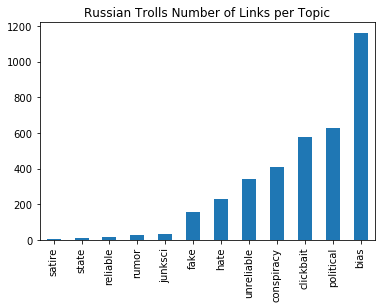

In [143]:
# we'll filter out the non-represented classes, sort them, and plot it!
breakdown[breakdown != 0].sort_values().plot(
    kind='bar', title='Russian Trolls Number of Links per Topic'
)

One hot encode all domains

In [218]:
df_dumb = pd.get_dummies(df_questionable, columns=['link.domain_resolved'], 
                         prefix='link_latent_')

In [213]:
vc = df_questionable['link.domain_resolved'].value_counts()
vc

youtu.be                          1355
www.breitbart.com                 1180
twibble.io                         945
www.youtube.com                    925
www.washingtonpost.com             713
dailycaller.com                    553
thehill.com                        398
www.sfgate.com                     396
ksnt.com                           390
www.cleveland.com                  360
www.foxnews.com                    349
www.kmbc.com                       331
www.thegatewaypundit.com           326
www.politico.com                   316
www.huffingtonpost.com             315
www.frontpagemag.com               312
truthfeed.com                      308
www.dailymail.co.uk                290
www.rt.com                         283
www.reuters.com                    280
www.nytimes.com                    262
www.usatoday.com                   260
www.nola.com                       240
www.americanthinker.com            234
nypost.com                         222
ksn.com                  

In [271]:
# all domains shared over 4 times
sites = vc[vc > 4].index.tolist()

In [273]:
dumb_cols = [c for c in df_dumb.columns if 'link_latent' in c and any(x in c for x in sites)]

In [274]:
one_hot_domains = df_dumb.groupby('user.id')[dumb_cols].sum()

In [300]:
def normalize(row):
    return row / row.sum()

In [302]:
one_hot_domains = one_hot_domains.apply(normalize)

In [307]:
one_hot_domains.head()

,link_latent__100percentfedup.com,link_latent__21stcenturywire.com,link_latent__2dopeboyz.com,link_latent__2ndamendmentfight.com,link_latent__3chicspolitico.com,link_latent__3tags.org,link_latent__4.nbcla.com,link_latent__4votingrights.com,link_latent__53eig.ht,link_latent__5csch,...,link_latent__www.zerohedge.com,link_latent__yen.com.gh,link_latent__youcaring.com,link_latent__yourblackworld.net,link_latent__yournewswire.com,link_latent__youtu.be,link_latent__youtube.com,link_latent__ytaclub.com,link_latent__zite.to,link_latent__zombietime.com
user.id,,,,,,,,,,,,,,,,,,,,,
100345056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.002952,0.0,0.0,0.0,0.0
1039581360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1497280638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1504356343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1510488662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [309]:
one_hot_domains_questionable = df_questionable.groupby('user.id')[media_classes].sum().fillna(0)
one_hot_domains_questionable = one_hot_domains_questionable.apply(normalize, axis=1).fillna(0)

In [276]:
from sklearn.manifold import TSNE

In [314]:
tsne = TSNE(n_components=2, learning_rate=150, verbose=2).fit_transform(one_hot_domains_questionable)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 335 samples in 0.000s...
[t-SNE] Computed neighbors for 335 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 335 / 335
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.024s
[t-SNE] Iteration 50: error = 56.1994743, gradient norm = 0.5941228 (50 iterations in 0.335s)
[t-SNE] Iteration 100: error = 58.6886673, gradient norm = 0.5355276 (50 iterations in 0.339s)
[t-SNE] Iteration 150: error = 55.3053513, gradient norm = 0.5972278 (50 iterations in 0.334s)
[t-SNE] Iteration 200: error = 58.9182205, gradient norm = 0.5205286 (50 iterations in 0.331s)
[t-SNE] Iteration 250: error = 55.5216179, gradient norm = 0.5873144 (50 iterations in 0.325s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.521618
[t-SNE] Iteration 300: error = 0.4028957, gradient norm = 0.0030278 (50 iterations in 0.297s)
[t-SNE] Iteration 350: error = 0.3909960, gradient norm = 0.0003483 (

In [315]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

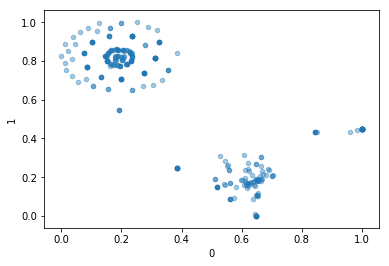

In [316]:
pd.DataFrame(list(zip(tx,ty))).plot.scatter(
    x=0, y=1, alpha = .4)

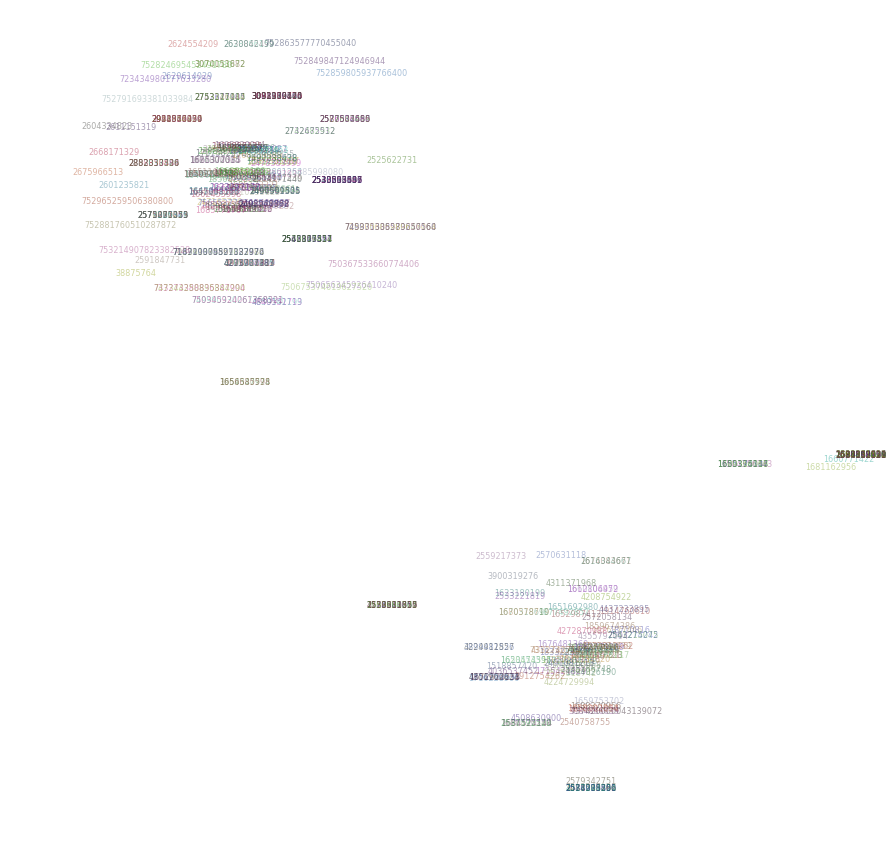

In [317]:
d1, d2 = 0, 1

dat = tsne
plt.figure(figsize=(15,15))
for label, x, y in zip(also_dope.index.values, dat[:, d1], dat[:, d2]):
    plt.text(x, y, label, color=np.random.rand(3)*0.7,
             fontsize=8, alpha = .4)

x_min, x_max = dat[:, 0].min() - 1, dat[:, 0].max() + 1
y_min, y_max = dat[:, 1].min() - 1, dat[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.axis('off')
plt.show();

# Temporal

In [46]:
dat1 = (df_questionable[(df_questionable['domain'].isnull()) 
                      & (df_questionable['tweet.created_at'] >= datetime.datetime(2016,6,1) )]
 ['tweet.created_at'].dt.date.value_counts()
).reset_index()

dat2 = (df_questionable[ ~df_questionable['domain'].isnull() ]
 ['tweet.created_at'].dt.date.value_counts()).reset_index()

dat1.sort_values(by='index', inplace=True)
dat2.sort_values(by='index', inplace=True)

merge = dat1.merge(dat2, on='index', how='outer')

def ratio(row):
    return row['tweet.created_at_y'] / row['tweet.created_at_x'] 

merge['ratio'] = merge.apply(ratio, axis=1)

In [114]:
merge['index'] = pd.to_datetime(merge['index'])
merge_ = merge[(~merge['ratio'].isnull()) & 
               (merge['index'] >= datetime.datetime(2016,7,17))]

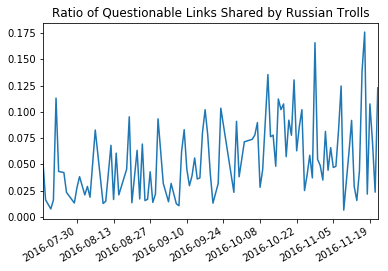

In [127]:
ax = merge_.plot(x='index', y='ratio', legend=False, 
                 title='Ratio of Questionable Links Shared by Russian Trolls')
ax.xaxis.label.set_visible(False)
fig = ax.get_figure()
fig.savefig('figs/ratio_questionable.png');

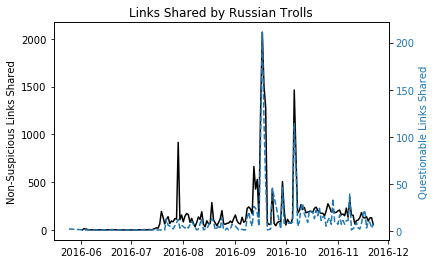

In [85]:
x1, y1 = dat1['index'], dat1['tweet.created_at']
x2, y2 = dat2['index'], dat2['tweet.created_at']

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x1, y1, color='k')
ax1.set_ylabel('Non-Suspicious Links Shared')

ax2 = ax1.twinx()
ax2.plot(x2, y2, '--')
ax2.set_ylabel('Questionable Links Shared', color='C0')
for tl in ax2.get_yticklabels():
    tl.set_color('C0')
plt.title("Links Shared by Russian Trolls")
plt.savefig('figs/links_shared.png')

In [133]:
spearmanr(merge_['tweet.created_at_x'], merge_['tweet.created_at_y'])

SpearmanrResult(correlation=0.8141942124014467, pvalue=4.5753648467005305e-26)